1. 找出测试集里面的 0 值, 将 0 值的发电量直接等于 0.379993053 (根据训练集)
2. 定位异常值
    - 大于均值+2倍标准差, 或者小于均值-2倍标准差
3. 修正异常值
    - 将异常值用上下记录均值来替代
4. 划分线下测试集, 使用均匀取样(类似测试集的取样方法)

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVR
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import xgboost as xgb
from lightgbm import LGBMRegressor
import math
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_data = pd.read_csv('../raw/public.train.csv')
test_data = pd.read_csv('../raw/public.test.csv')

In [3]:
df_result = pd.DataFrame()
df_result['ID'] = test_data['ID']
special_missing_ID = test_data[test_data['平均功率'] == 0]['ID'] 

In [4]:
all_data = pd.concat([train_data, test_data], axis=0).sort_values(by='ID').reset_index().drop(['index'], axis=1)

In [5]:
bad_feature = ['ID', '功率A', '功率B', '功率C', '平均功率', '现场温度', '电压A', '电压B', '电压C', '电流B', '电流C', '转换效率', '转换效率A', '转换效率B', '转换效率C']

In [6]:
bad_index = all_data[bad_feature][
    (all_data[bad_feature] > all_data[bad_feature].mean() + 2 * all_data[bad_feature].std()) | 
    (all_data[bad_feature] < all_data[bad_feature].mean() - 2 * all_data[bad_feature].std())
].dropna(how='all').index

In [7]:
nn_bad_data = all_data.loc[np.concatenate([bad_index - 1, bad_index, bad_index + 1])].sort_values(by='ID', ascending=True).drop_duplicates()

In [8]:
bad_data = all_data.loc[bad_index].sort_values(by='ID', ascending=True)

In [9]:
# 上下记录均值替代异常值
for idx, line in bad_data.iterrows():
    ID = line['ID']
    col_index = line[bad_feature][
        (line[bad_feature] > all_data[bad_feature].mean() + 2 * all_data[bad_feature].std())| 
        (line[bad_feature] < all_data[bad_feature].mean() - 2 * all_data[bad_feature].std())
    ].index
    index = all_data[all_data['ID'] == ID].index
    
    before_offset = 1
    while (idx + before_offset)in bad_index:
        before_offset += 1
    
    after_offset = 1
    while (idx + after_offset) in bad_index:
        after_offset += 1
        
    replace_value = (all_data.loc[index - before_offset, col_index].values + all_data.loc[index + after_offset, col_index].values) / 2
    all_data.loc[index, col_index] = replace_value[0]

In [237]:
all_data.to_csv('../raw/all_data.csv',index=False)  

### 拆分数据

In [239]:
test_data = all_data[all_data['ID'].isin(df_result['ID'])].drop(['发电量'], axis=1).reset_index().drop(['index'], axis=1)
len(test_data)
# test_data.to_csv('../raw/test_data.csv',index=False)  

In [240]:
train_data = all_data.drop(all_data[all_data['ID'].isin(df_result['ID'])].index).reset_index().drop(['index'], axis=1)
len(train_data)
train_data.to_csv('../raw/train_data.csv',index=False) 

In [2]:
train_data = pd.read_csv('../raw/train_data.csv')
test_data = pd.read_csv('../raw/test_data.csv')

In [3]:
# 去重
train_data.drop_duplicates(train_data.columns.drop('ID'), keep='first', inplace=True)
len(train_data)

8918

In [43]:
def generate_train_data(train_data, test_data, poly=False, select=False):

    y = train_data['发电量']
    X = train_data.drop(['发电量','ID'], axis=1)
    sub_data = test_data.drop(['ID'], axis=1)

    if poly:
        from sklearn.preprocessing import PolynomialFeatures
        poly = PolynomialFeatures(degree=2, interaction_only=True)
        X = poly.fit_transform(X)
        sub_data = poly.transform(sub_data)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if select:
        from sklearn.feature_selection import SelectFromModel
        sm = SelectFromModel(GradientBoostingRegressor(random_state=2))
        X_train = sm.fit_transform(X_train, y_train)
        X_test = sm.transform(X_test)
        sub_data = sm.transform(sub_data)
        
    return X_train, X_test, y_train, y_test, sub_data

In [50]:
# 全部数据集 X, y
def generate_train_data(train_data, test_data, poly=False, select=False):

    y = train_data['发电量']
    X = train_data.drop(['发电量','ID'], axis=1)
    sub_data = test_data.drop(['ID'], axis=1)

    if poly:
        from sklearn.preprocessing import PolynomialFeatures
        poly = PolynomialFeatures(degree=2, interaction_only=True)
        X = poly.fit_transform(X)
        sub_data = poly.transform(sub_data)
        
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if select:
        from sklearn.feature_selection import SelectFromModel
        sm = SelectFromModel(GradientBoostingRegressor(random_state=2))
        X = sm.fit_transform(X, y)
#         X_test = sm.transform(X_test)
        sub_data = sm.transform(sub_data)
        
    return X, y, sub_data

In [51]:
X, y, sub_data = generate_train_data(train_data, test_data, poly=True, select=True)
print(X.shape, sub_data.shape)

(8918, 49) (8409, 49)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, sub_data.shape)

(7134, 49) (8409, 49)


In [5]:
def cal_score(mse):
    return 1 / (1 + math.sqrt(mse))

In [44]:
X_train, X_test, y_train, y_test, sub_data = generate_train_data(train_data, test_data, poly=True, select=True)
print(X_train.shape, sub_data.shape)

(7134, 54) (8409, 54)


In [59]:
import scipy as sp

In [60]:
trainset = xgb.DMatrix(X,label=y)
testset = xgb.DMatrix(X_test)

params = {
'booster': 'gbtree', # 基于树的模型进行计算`
'objective': 'reg:linear', # 线性回归
'eval_metric': 'rmse', # RMSE 评价函数
'gamma': 0.1, # 在树的叶子节点上进一步划分所需的最小损失减少。算法越大，越保守。
'min_child_weight': 1.1, # 孩子节点中最小的样本权重和。如果一个叶子节点的样本权重和小于min_child_weight则拆分过程结束。
'max_depth': 6, # 树的最大深度。缺省值为6
'lambda': 10, # L2 正则的惩罚系数
'subsample': 0.8, # 用于训练模型的子样本占整个样本集合的比例。
'colsample_bytree': 0.8, # 在建立树时对特征采样的比例。
'tree_method': 'exact' # 树的构造算法-Exact greedy algorithm(确切贪心算法)
}

watchlist = [(trainset,'train')]
model = xgb.train(params, trainset, num_boost_round=4000)
predict_test_X = model.predict(testset)
rmsetmp = sp.sqrt(sp.mean((y_test - predict_test_X) ** 2))
score = 1 / (1 + rmsetmp)
print('This time score is: '+ str(score))

This time score is: 0.9423727536000328


- round=4000, score: 0.8674
- round=3500, score: 0.8671
- round=4200, score: 0.8674
- round=4500, score: 0.8674

换了个 random_seed =42(之前2), 并且 feature 减少了一个
- round=4000, score: 0.8557

如果不进行 Poly 和 select
- round=4000, score: 0.8734 目前最高

如果只进行  seclect
- round=4000, score: 0.8630

如果只进行 poly
- round=4000, score: 0.8582

调参
- round=4000, score: 0.8806

全数据
- round=4000, score: 0.9423

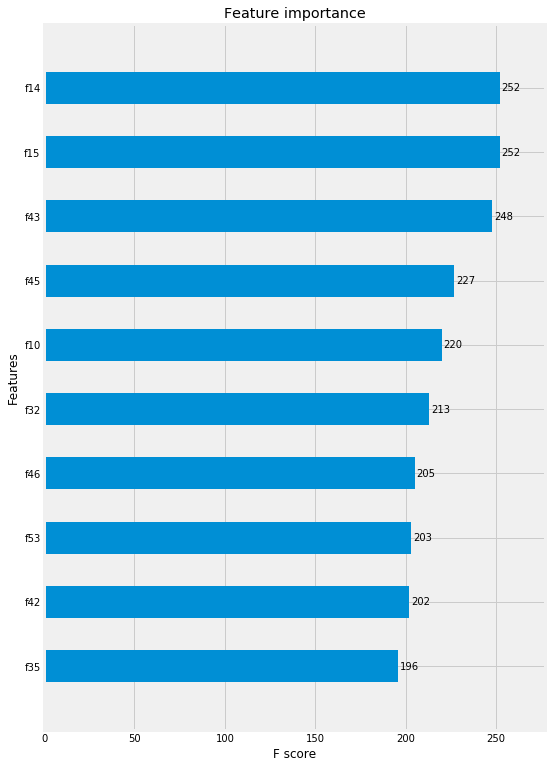

In [246]:
# 分析重要性
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=10, height=0.5, ax=ax)

In [61]:
test_set = xgb.DMatrix(sub_data)
prediction2 = model.predict(test_set)

In [62]:
df_result['score'] = prediction2
index = df_result[df_result['ID'].isin(special_missing_ID)].index
df_result.loc[index, 'score'] = 0.379993053

In [63]:
rmse = sp.sqrt(sp.mean((prediction - prediction2) ** 2))
score = 1 / (1 + rmse)
score

0.9171276429140061

In [64]:
df_result.to_csv('./results/result_20180805a_xgboost-alldata.csv',index=False, header=False)  

## lightgbm

In [23]:
import lightgbm as lgb

In [24]:
lgb_train = lgb.Dataset(X, y)
lgb_test = lgb.Dataset(X_test, y_test)

params = {
'learning_rate': 0.002,
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'sub_feature': 0.5,
'num_leaves': 90,
'min_data': 55,
'min_hessian': 1,
'verbose': -1,}

gbm = lgb.train(params, lgb_train, 4000)
pred = gbm.predict(X_test)
rmsetmp = sp.sqrt(sp.mean((y_test - pred) ** 2))
score = 1 / (1 + rmsetmp)

print('This time score is: '+ str(score))

This time score is: 0.9437239257296771


* 如果不进行 ploy 和 select,  score: 0.8900
* 如果进行 select, score: 0.8798
* 如果进行 Ploy , 但是不进行 select, score: 0.8965
* 如果同时进行 ploy 和 select, score: 0.8940
* 调参, poly + select , score: 0.8971
* 调参, poly + no select, score: 0.9003
* 使用全数据,调参 poly + no select, score: 0.9437, 线上: 

In [25]:
prediction = gbm.predict(sub_data)

In [26]:
df_result['score'] = prediction

In [27]:
index = df_result[df_result['ID'].isin(special_missing_ID)].index
df_result.loc[index, 'score'] = 0.379993053

In [58]:
rmse = sp.sqrt(sp.mean((prediction - prediction3) ** 2))
score = 1 / (1 + rmse)
score

0.9430677973790185

In [29]:
df_result.to_csv('./results/result_20180805a_lightgbm-alldata.csv',index=False, header=False)  

## GBRT

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
est = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.1,
         max_depth=6, random_state=0, loss='ls').fit(X, y)

In [53]:
prediction3 = est.predict(X_test)

In [54]:
rmse = sp.sqrt(sp.mean((y_test - prediction3) ** 2))

In [55]:
score = 1 / (1 + rmse)
score

0.9971430409442621

- max_depth=6 score:0.8924
- max_depth=5 score:0.8919
- max_depth=7 score:0.8917

- n_estimators=500 score:0.8925
- n_estimators=1000 score:0.8928
- n_estimators=2000 score:0.8929
- n_estimators=4000 score:0.8929

In [57]:
prediction3 = est.predict(sub_data)

In [37]:
df_result['score'] = prediction3

In [38]:
index = df_result[df_result['ID'].isin(special_missing_ID)].index
df_result.loc[index, 'score'] = 0.379993053
df_result.loc[index]

,ID,score
0,1,0.379993
425,940,0.379993
754,1694,0.379993
841,1879,0.379993
1276,2823,0.379993
1427,3202,0.379993
1979,4459,0.379993
2068,4648,0.379993
2139,4821,0.379993
2217,5010,0.379993


In [39]:
df_result.to_csv('./results/result_20180805a_GBRT_alldata.csv',index=False, header=False)  

## RandomForest

In [65]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
rfr = RandomForestRegressor(n_estimators=800, max_features='sqrt', random_state=7, n_jobs=8)

In [68]:
rfr.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=8,
           oob_score=False, random_state=7, verbose=0, warm_start=False)

In [69]:
prediction4 = rfr.predict(sub_data)

In [70]:
df_result['score'] = prediction4

In [71]:
index = df_result[df_result['ID'].isin(special_missing_ID)].index
df_result.loc[index, 'score'] = 0.379993053
df_result.loc[index]

,ID,score
0,1,0.379993
425,940,0.379993
754,1694,0.379993
841,1879,0.379993
1276,2823,0.379993
1427,3202,0.379993
1979,4459,0.379993
2068,4648,0.379993
2139,4821,0.379993
2217,5010,0.379993


In [73]:
rmse = sp.sqrt(sp.mean((prediction - prediction4) ** 2))
score = 1 / (1 + rmse)
score

0.9485643568709655

In [72]:
df_result.to_csv('./results/result_20180806a_randomforest_alldata.csv',index=False, header=False)  